In [ ]:
!pip install easyocr jiwer opencv-python
!pip install opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.2/978.2 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 15.3 MB/s eta 0:00:00


In [ ]:
import easyocr
import cv2
import json
import glob
import random
import os
import matplotlib.pyplot as plt
from jiwer import wer, cer
import numpy as np
import opendatasets as od

In [4]:
dataset_url = 'https://www.kaggle.com/datasets/senju14/ocr-dataset-of-multi-type-documents'
od.download(dataset_url)

data_dir = './ocr-dataset-of-multi-type-documents'
print(f"Dataset downloaded to: {data_dir}")
print(f"Contents: {os.listdir(data_dir)}")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/senju14/ocr-dataset-of-multi-type-documents


100%|██████████| 5.16G/5.16G [01:31<00:00, 60.4MB/s]



Dataset downloaded to: ./ocr-dataset-of-multi-type-documents
Contents: ['invoice', 'form', 'document', 'real_life']


In [ ]:
def get_data_from_json(json_path):

    with open(json_path, 'r') as f:
      data = json.load(f)

    if 'form' in data and 'lines' in data:
      img_id = data['form']['id']
      all_lines = [line['text'] for line in data['lines'] if 'text' in line]
      ground_truth = " ".join(all_lines)
      return img_id, ground_truth
    else:
      return None, None

Loading EasyOCR Model... (this might take a moment)
Found 2711 JSON files.

==================== EASYOCR EVALUATION START ====================



/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


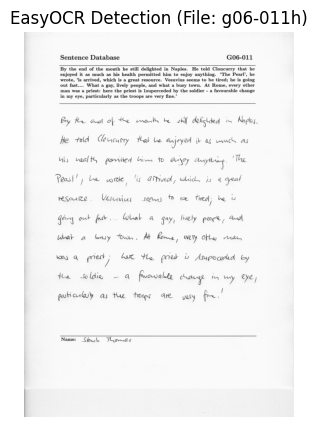

Ground Truth: Sentence Database G06-011 the end of the month he still delighted in Naples. He told Cloncurry that ...
EasyOCR Pred: Sentence Database G06-011 the end of the month he still delighted in Naples. He told Cloncurry that ...
METRICS ->    CER: 0.0119 | WER: 0.0309
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


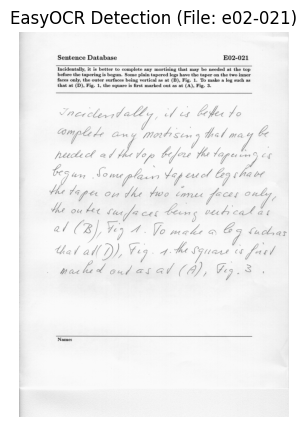

Ground Truth: Sentence Database E02-021 Incidentally, it is better to complete any mortising that may be needed at...
EasyOCR Pred: Sentence Database E02-021 Incidentally, it is better to complete any mortising that may be needed at...
METRICS ->    CER: 0.0256 | WER: 0.0875
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


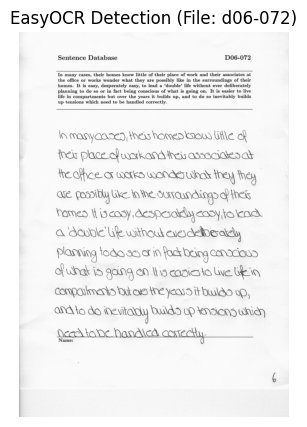

Ground Truth: Sentence Database D06-072 In many cases, their homes know little of their place of work and their as...
EasyOCR Pred: Sentence Database D06-072 In many cases, their homes know little of their place of work and their as...
METRICS ->    CER: 0.0287 | WER: 0.1301
------------------------------------------------------------


In [5]:

DATASET_ROOT = '/content/ocr-dataset-of-multi-type-documents'
USE_GPU = True

# Initializing OCR
reader = easyocr.Reader(['en'], gpu=USE_GPU)


all_json_files = glob.glob(f"{DATASET_ROOT}/**/*.json", recursive=True)


random.shuffle(all_json_files)

target_samples = 3
processed_count = 0


for json_path in all_json_files:
    if processed_count >= target_samples:
        break

    # Get Ground Truth
    img_id, ground_truth = get_data_from_json(json_path)
    if not img_id: continue

    #Find Matching Image
    found_img_path = None
    for ext in ['png', 'jpg', 'jpeg', 'tif', 'bmp']:
        matches = glob.glob(f"{DATASET_ROOT}/**/{img_id}.{ext}", recursive=True)
        if matches:
            found_img_path = matches[0]
            break

    if not found_img_path: continue

    #Load Image
    image = cv2.imread(found_img_path)
    if image is None: continue

    # Run EasyOCR Inference
    try:
        results = reader.readtext(found_img_path, detail=1)
    except Exception as e:
        print(f"EasyOCR Error on {img_id}: {e}")
        continue

    predicted_text_list = [res[1] for res in results]
    predicted_text = " ".join(predicted_text_list)

    #  Compute Metrics
    clean_truth = " ".join(ground_truth.split())
    clean_pred = " ".join(predicted_text.split())

    if not clean_pred.strip():
        c_err, w_err = 1.0, 1.0
    else:
        c_err = cer(clean_truth, clean_pred)
        w_err = wer(clean_truth, clean_pred)

    #Visualization
    processed_count += 1

    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    for (bbox, text, prob) in results:
        top_left = tuple(map(int, bbox[0]))
        bottom_right = tuple(map(int, bbox[2]))
        image = cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)

    plt.title(f"EasyOCR Detection (File: {img_id})")
    plt.axis('off')
    plt.show()

    print(f"Ground Truth: {clean_truth[:100]}...")
    print(f"EasyOCR Pred: {clean_pred[:100]}...")
    print(f"METRICS :   CER: {c_err:.4f} | WER: {w_err:.4f}")
    print("-" * 60)